# 05 — Evaluation
### CSC 577 | Team Rocket | Food.com Recipe Recommender

This notebook evaluates all system variants using the metrics from the project proposal:

| Metric | What it measures |
|---|---|
| **RMSE / MAE** | Rating prediction accuracy |
| **Precision@K** | Of the top-K recommendations, how many did the user actually like? |
| **Recall@K** | Of all recipes the user liked, how many appear in the top-K? |
| **Constraint Satisfaction Rate (CSR)** | % of recommendations that satisfy ingredient constraints |

**Systems compared:**
1. UB-CF only
2. SVD only
3. UB-CF + Hard constraint
4. UB-CF + Soft constraint
5. SVD + Hard constraint
6. SVD + Soft constraint

**Inputs:** all files from `data/processed/`  
**Outputs:** `results/metrics_comparison.csv`, all plots saved to `results/`

## 0. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import os

sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.dpi'] = 100
os.makedirs('../results', exist_ok=True)

print('Libraries loaded.')

Libraries loaded.


## 1. Load All Data

In [2]:
# Test set with model predictions
test_preds = pd.read_csv('../data/processed/test_with_predictions.csv')

# CF candidate lists (unconstrained)
ubcf_cands = pd.read_csv('../data/processed/cf_ubased_candidates.csv')
svd_cands  = pd.read_csv('../data/processed/cf_svd_candidates.csv')

# Constrained candidate lists
ubcf_hard  = pd.read_csv('../data/processed/constrained_ubcf_hard.csv')
ubcf_soft  = pd.read_csv('../data/processed/constrained_ubcf_soft.csv')
svd_hard   = pd.read_csv('../data/processed/constrained_svd_hard.csv')
svd_soft   = pd.read_csv('../data/processed/constrained_svd_soft.csv')

# Ground truth interactions
test_df    = pd.read_csv('../data/processed/test.csv')

print(f'Test predictions:  {len(test_preds):,} rows')
print(f'Test interactions: {len(test_df):,} rows')
print(f'UB-CF candidates:  {len(ubcf_cands):,} rows')
print(f'SVD candidates:    {len(svd_cands):,} rows')

Test predictions:  97,507 rows
Test interactions: 97,522 rows
UB-CF candidates:  181,740 rows
SVD candidates:    181,740 rows


## 2. Rating Prediction Accuracy — RMSE & MAE

Computed on the held-out test set. Only UB-CF and SVD have predicted ratings — constrained models inherit these scores (constraint filtering is a re-ranking step, not a new predictor).

In [3]:
def rmse(actual, predicted):
    return float(np.sqrt(np.mean((np.array(actual) - np.array(predicted)) ** 2)))

def mae(actual, predicted):
    return float(np.mean(np.abs(np.array(actual) - np.array(predicted))))

actual = test_preds['rating'].values

# Baseline: always predict the global mean rating
global_mean = test_preds['rating'].mean()
baseline_preds = np.full_like(actual, global_mean, dtype=float)

accuracy_results = {
    'Model':  ['Baseline (global mean)', 'User-Based CF', 'SVD'],
    'RMSE':   [
        rmse(actual, baseline_preds),
        rmse(actual, test_preds['ubcf_pred'].values),
        rmse(actual, test_preds['svd_pred'].values),
    ],
    'MAE':    [
        mae(actual, baseline_preds),
        mae(actual, test_preds['ubcf_pred'].values),
        mae(actual, test_preds['svd_pred'].values),
    ],
}
accuracy_df = pd.DataFrame(accuracy_results)
accuracy_df['RMSE'] = accuracy_df['RMSE'].round(4)
accuracy_df['MAE']  = accuracy_df['MAE'].round(4)

print('=== Rating Prediction Accuracy ===')
print(accuracy_df.to_string(index=False))

=== Rating Prediction Accuracy ===
                 Model   RMSE    MAE
Baseline (global mean) 0.5996 0.4240
         User-Based CF 0.6182 0.3660
                   SVD 0.5609 0.3544


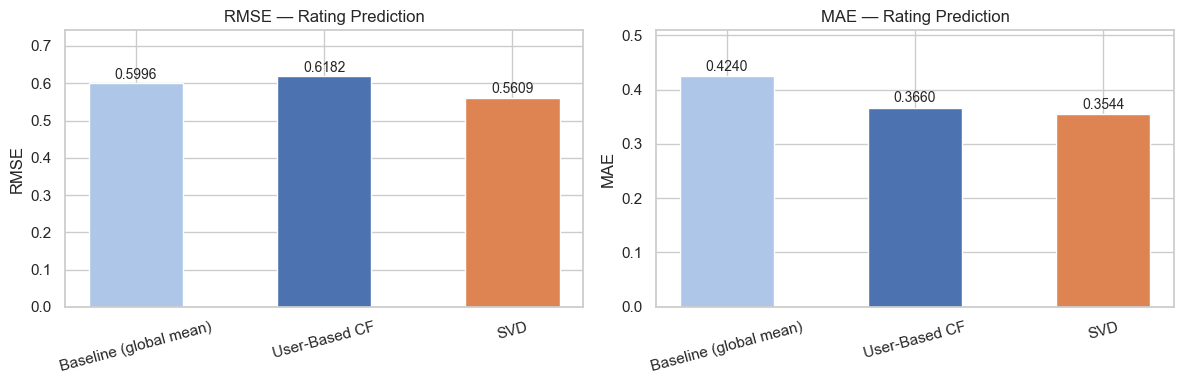

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

colors = ['#aec7e8', '#4C72B0', '#DD8452']

for ax, metric in zip(axes, ['RMSE', 'MAE']):
    bars = ax.bar(accuracy_df['Model'], accuracy_df[metric],
                  color=colors, edgecolor='white', width=0.5)
    for bar, val in zip(bars, accuracy_df[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{val:.4f}', ha='center', va='bottom', fontsize=10)
    ax.set_title(f'{metric} — Rating Prediction', fontsize=12)
    ax.set_ylabel(metric)
    ax.set_ylim(0, accuracy_df[metric].max() * 1.2)
    ax.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig('../results/rmse_mae.png', bbox_inches='tight')
plt.show()

## 3. Precision@K and Recall@K

**Definitions:**
- A recommendation is **relevant** if the user actually rated that recipe ≥ `RELEVANCE_THRESHOLD` in the test set
- **Precision@K** = (relevant recipes in top-K) / K
- **Recall@K** = (relevant recipes in top-K) / (total relevant recipes for this user)

We average these across all users.

In [5]:
RELEVANCE_THRESHOLD = 4   # a recipe is "liked" if rated >= 4
K_VALUES = [5, 10, 20]    # evaluate at multiple K

# Build ground truth: for each user, the set of recipe_ids they liked in the test set
liked = (
    test_df[test_df['rating'] >= RELEVANCE_THRESHOLD]
    .groupby('user_id')['recipe_id']
    .apply(set)
    .to_dict()
)

print(f'Relevance threshold: rating >= {RELEVANCE_THRESHOLD}')
print(f'Users with at least 1 liked recipe in test set: {len(liked):,}')

Relevance threshold: rating >= 4
Users with at least 1 liked recipe in test set: 9,078


In [6]:
def precision_recall_at_k(candidates_df, liked_dict, k):
    """
    Compute mean Precision@K and Recall@K across all users.

    candidates_df must have columns: user_id, recipe_id, rank
    liked_dict: {user_id: set of liked recipe_ids}
    """
    precisions, recalls = [], []

    users_in_both = set(candidates_df['user_id'].unique()) & set(liked_dict.keys())

    for user_id in users_in_both:
        user_liked = liked_dict[user_id]
        if not user_liked:
            continue

        # Top-K recommendations for this user (sorted by rank)
        user_recs = (
            candidates_df[candidates_df['user_id'] == user_id]
            .sort_values('rank')
            .head(k)['recipe_id']
            .tolist()
        )

        if not user_recs:
            continue

        n_relevant = len(set(user_recs) & user_liked)
        precisions.append(n_relevant / k)
        recalls.append(n_relevant / len(user_liked))

    return (
        round(np.mean(precisions), 4) if precisions else 0.0,
        round(np.mean(recalls),   4) if recalls    else 0.0
    )


# Systems to evaluate
systems = {
    'UB-CF':            ubcf_cands,
    'SVD':              svd_cands,
    'UB-CF + Hard':     ubcf_hard,
    'UB-CF + Soft':     ubcf_soft,
    'SVD + Hard':       svd_hard,
    'SVD + Soft':       svd_soft,
}

# Compute metrics for each system and each K
pr_rows = []
for system_name, cands_df in systems.items():
    for k in K_VALUES:
        p, r = precision_recall_at_k(cands_df, liked, k)
        pr_rows.append({
            'System':        system_name,
            'K':             k,
            'Precision@K':   p,
            'Recall@K':      r,
        })

pr_df = pd.DataFrame(pr_rows)
print('=== Precision@K and Recall@K ===')
print(pr_df.pivot(index='System', columns='K', values=['Precision@K', 'Recall@K']).to_string())

=== Precision@K and Recall@K ===
             Precision@K                 Recall@K                
K                     5       10      20       5       10      20
System                                                           
SVD               0.0067  0.0048  0.0038   0.0045  0.0064  0.0099
SVD + Hard        0.0098  0.0049  0.0024   0.0064  0.0064  0.0064
SVD + Soft        0.0080  0.0052  0.0027   0.0061  0.0069  0.0069
UB-CF             0.0004  0.0003  0.0003   0.0002  0.0003  0.0007
UB-CF + Hard      0.0029  0.0015  0.0007   0.0016  0.0016  0.0016
UB-CF + Soft      0.0009  0.0005  0.0003   0.0005  0.0005  0.0005


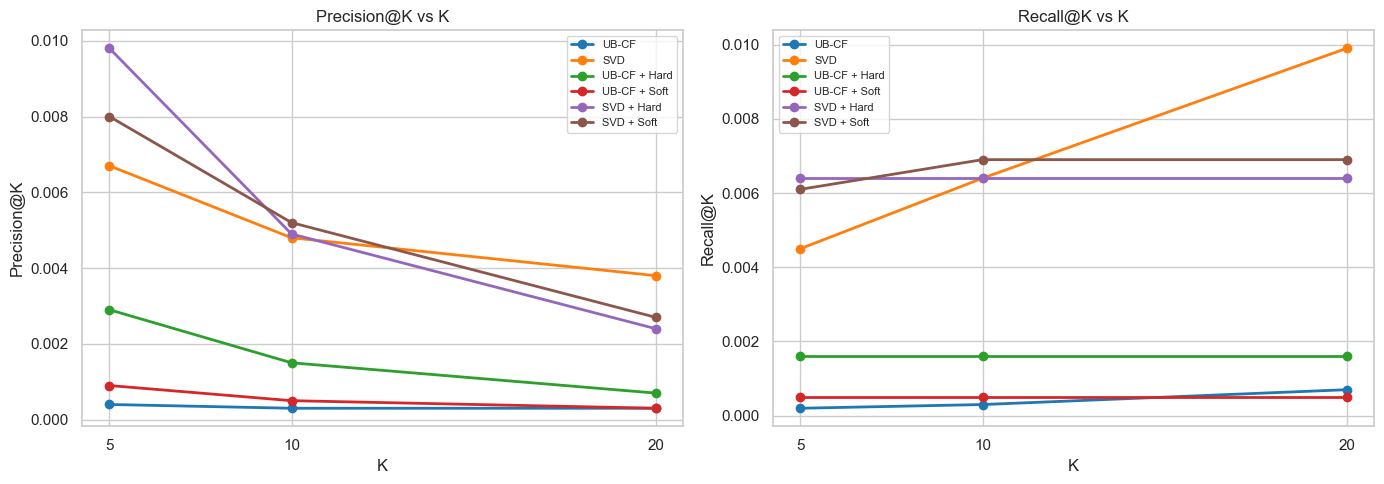

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

palette = sns.color_palette('tab10', n_colors=len(systems))

for ax, metric in zip(axes, ['Precision@K', 'Recall@K']):
    for (system_name, _), color in zip(systems.items(), palette):
        subset = pr_df[pr_df['System'] == system_name]
        ax.plot(subset['K'], subset[metric], marker='o', label=system_name,
                color=color, linewidth=2)
    ax.set_title(f'{metric} vs K', fontsize=12)
    ax.set_xlabel('K')
    ax.set_ylabel(metric)
    ax.set_xticks(K_VALUES)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig('../results/precision_recall_at_k.png', bbox_inches='tight')
plt.show()

## 4. Constraint Satisfaction Rate (CSR)

CSR = percentage of recommended recipes that satisfy the ingredient constraint.

- For **unconstrained** CF: we compute CSR post-hoc (what fraction would have satisfied hard/soft constraints anyway)
- For **constrained** systems: CSR is 100% by construction for hard, and guaranteed ≤ `max_missing` for soft

In [8]:
def compute_csr(df, constraint='hard', max_missing=3):
    """Compute Constraint Satisfaction Rate from a recommendations dataframe."""
    if 'n_missing' not in df.columns:
        # Unconstrained — CSR not applicable, return None
        return None
    if constraint == 'hard':
        satisfied = (df['n_missing'] == 0).sum()
    else:
        satisfied = (df['n_missing'] <= max_missing).sum()
    return round(satisfied / len(df) * 100, 2)


csr_rows = [
    {'System': 'UB-CF (no constraint)',  'Hard CSR (%)': 'N/A', 'Soft CSR (%)': 'N/A'},
    {'System': 'SVD (no constraint)',    'Hard CSR (%)': 'N/A', 'Soft CSR (%)': 'N/A'},
    {'System': 'UB-CF + Hard',  'Hard CSR (%)': compute_csr(ubcf_hard, 'hard'), 'Soft CSR (%)': 'N/A'},
    {'System': 'UB-CF + Soft',  'Hard CSR (%)': compute_csr(ubcf_soft, 'hard'),
                                'Soft CSR (%)': compute_csr(ubcf_soft, 'soft')},
    {'System': 'SVD + Hard',    'Hard CSR (%)': compute_csr(svd_hard, 'hard'),  'Soft CSR (%)': 'N/A'},
    {'System': 'SVD + Soft',    'Hard CSR (%)': compute_csr(svd_soft, 'hard'),
                                'Soft CSR (%)': compute_csr(svd_soft, 'soft')},
]
csr_results_df = pd.DataFrame(csr_rows)
print('=== Constraint Satisfaction Rate ===')
print(csr_results_df.to_string(index=False))

=== Constraint Satisfaction Rate ===
               System Hard CSR (%) Soft CSR (%)
UB-CF (no constraint)          N/A          N/A
  SVD (no constraint)          N/A          N/A
         UB-CF + Hard        100.0          N/A
         UB-CF + Soft         1.79        100.0
           SVD + Hard        100.0          N/A
           SVD + Soft         2.77        100.0


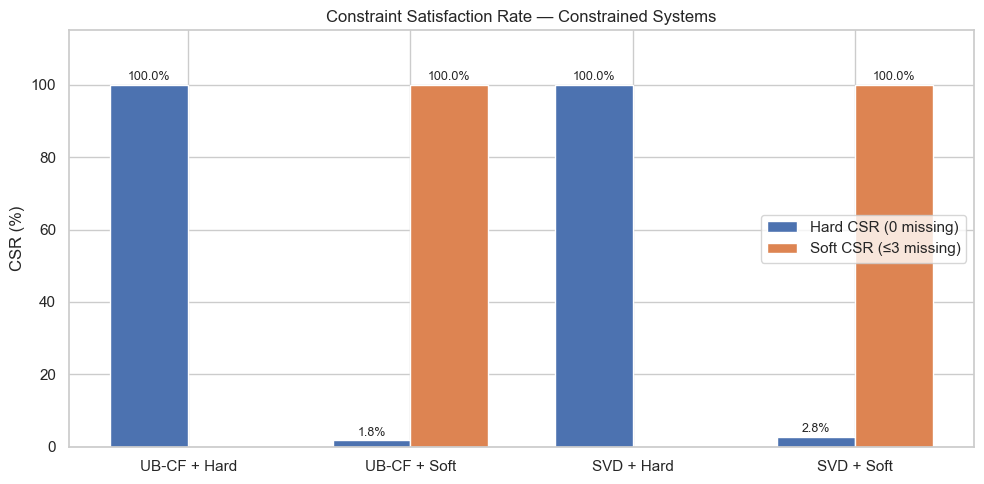

In [9]:
# Bar chart — only the constrained systems have real CSR values
csr_plot_df = pd.DataFrame({
    'System':     ['UB-CF + Hard', 'UB-CF + Soft', 'SVD + Hard', 'SVD + Soft'],
    'Hard CSR':   [
        compute_csr(ubcf_hard, 'hard'),
        compute_csr(ubcf_soft, 'hard'),
        compute_csr(svd_hard,  'hard'),
        compute_csr(svd_soft,  'hard'),
    ],
    'Soft CSR':   [
        None,
        compute_csr(ubcf_soft, 'soft'),
        None,
        compute_csr(svd_soft,  'soft'),
    ],
})

x = np.arange(len(csr_plot_df))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.bar(x - width/2, csr_plot_df['Hard CSR'], width,
               label='Hard CSR (0 missing)', color='#4C72B0', edgecolor='white')
# Only plot soft CSR where it exists
soft_vals = [v if v is not None else 0 for v in csr_plot_df['Soft CSR']]
bars2 = ax.bar(x + width/2, soft_vals, width,
               label='Soft CSR (≤3 missing)', color='#DD8452', edgecolor='white')

for bar, val in zip(bars1, csr_plot_df['Hard CSR']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=9)
for bar, val in zip(bars2, soft_vals):
    if val > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=9)

ax.set_title('Constraint Satisfaction Rate — Constrained Systems', fontsize=12)
ax.set_ylabel('CSR (%)')
ax.set_xticks(x)
ax.set_xticklabels(csr_plot_df['System'])
ax.set_ylim(0, 115)
ax.legend()

plt.tight_layout()
plt.savefig('../results/csr_comparison.png', bbox_inches='tight')
plt.show()

## 5. Trade-off Analysis — Precision@10 vs CSR

Adding ingredient constraints improves feasibility (CSR) but may reduce recommendation quality (Precision). This plot shows that trade-off explicitly.

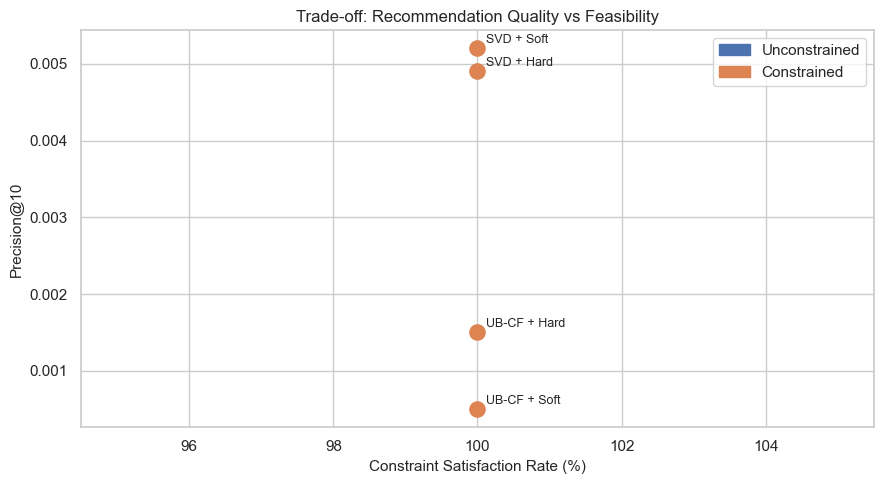

In [10]:
# Get Precision@10 for each constrained system
tradeoff_systems = {
    'UB-CF':        (ubcf_cands, None),
    'UB-CF + Hard': (ubcf_hard,  compute_csr(ubcf_hard, 'hard')),
    'UB-CF + Soft': (ubcf_soft,  compute_csr(ubcf_soft, 'soft')),
    'SVD':          (svd_cands,  None),
    'SVD + Hard':   (svd_hard,   compute_csr(svd_hard,  'hard')),
    'SVD + Soft':   (svd_soft,   compute_csr(svd_soft,  'soft')),
}

tradeoff_rows = []
for name, (df, csr_val) in tradeoff_systems.items():
    p10, _ = precision_recall_at_k(df, liked, k=10)
    tradeoff_rows.append({
        'System':       name,
        'Precision@10': p10,
        'CSR (%)':      csr_val if csr_val is not None else float('nan'),
        'Type':         'Constrained' if '+' in name else 'Unconstrained'
    })
tradeoff_df = pd.DataFrame(tradeoff_rows)

# Scatter plot
fig, ax = plt.subplots(figsize=(9, 5))
colors_map = {'Unconstrained': '#4C72B0', 'Constrained': '#DD8452'}

for _, row in tradeoff_df.iterrows():
    if not np.isnan(row['CSR (%)']):
        ax.scatter(row['CSR (%)'], row['Precision@10'],
                   color=colors_map[row['Type']], s=120, zorder=5)
        ax.annotate(row['System'],
                    (row['CSR (%)'], row['Precision@10']),
                    textcoords='offset points', xytext=(6, 4), fontsize=9)

ax.set_xlabel('Constraint Satisfaction Rate (%)', fontsize=11)
ax.set_ylabel('Precision@10', fontsize=11)
ax.set_title('Trade-off: Recommendation Quality vs Feasibility', fontsize=12)
from matplotlib.patches import Patch
legend_els = [Patch(color='#4C72B0', label='Unconstrained'),
              Patch(color='#DD8452', label='Constrained')]
ax.legend(handles=legend_els)

plt.tight_layout()
plt.savefig('../results/tradeoff_precision_csr.png', bbox_inches='tight')
plt.show()

## 6. Full Results Table

In [11]:
# Build the complete metrics table
all_systems = {
    'UB-CF':        ubcf_cands,
    'SVD':          svd_cands,
    'UB-CF + Hard': ubcf_hard,
    'UB-CF + Soft': ubcf_soft,
    'SVD + Hard':   svd_hard,
    'SVD + Soft':   svd_soft,
}

final_rows = []
for name, df in all_systems.items():
    p5,  r5  = precision_recall_at_k(df, liked, 5)
    p10, r10 = precision_recall_at_k(df, liked, 10)
    p20, r20 = precision_recall_at_k(df, liked, 20)

    # RMSE/MAE only for base CF models
    if name == 'UB-CF':
        row_rmse = rmse(actual, test_preds['ubcf_pred'].values)
        row_mae  = mae(actual,  test_preds['ubcf_pred'].values)
    elif name == 'SVD':
        row_rmse = rmse(actual, test_preds['svd_pred'].values)
        row_mae  = mae(actual,  test_preds['svd_pred'].values)
    else:
        row_rmse = '—'
        row_mae  = '—'

    # CSR
    if 'Hard' in name:
        csr = f"{compute_csr(df, 'hard'):.1f}%"
    elif 'Soft' in name:
        csr = f"{compute_csr(df, 'soft'):.1f}%"
    else:
        csr = 'N/A'

    final_rows.append({
        'System':       name,
        'RMSE':         row_rmse,
        'MAE':          row_mae,
        'Precision@5':  p5,
        'Recall@5':     r5,
        'Precision@10': p10,
        'Recall@10':    r10,
        'Precision@20': p20,
        'Recall@20':    r20,
        'CSR':          csr,
    })

final_df = pd.DataFrame(final_rows)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
print('=== FULL RESULTS TABLE ===')
print(final_df.to_string(index=False))

=== FULL RESULTS TABLE ===
      System      RMSE       MAE  Precision@5  Recall@5  Precision@10  Recall@10  Precision@20  Recall@20    CSR
       UB-CF  0.618223  0.366013       0.0004    0.0002        0.0003     0.0003        0.0003     0.0007    N/A
         SVD  0.560937  0.354364       0.0067    0.0045        0.0048     0.0064        0.0038     0.0099    N/A
UB-CF + Hard         —         —       0.0029    0.0016        0.0015     0.0016        0.0007     0.0016 100.0%
UB-CF + Soft         —         —       0.0009    0.0005        0.0005     0.0005        0.0003     0.0005 100.0%
  SVD + Hard         —         —       0.0098    0.0064        0.0049     0.0064        0.0024     0.0064 100.0%
  SVD + Soft         —         —       0.0080    0.0061        0.0052     0.0069        0.0027     0.0069 100.0%


In [12]:
# Save full results to CSV
final_df.to_csv('../results/metrics_comparison.csv', index=False)
print('Saved results/metrics_comparison.csv')

Saved results/metrics_comparison.csv


## 7. Summary Heatmap

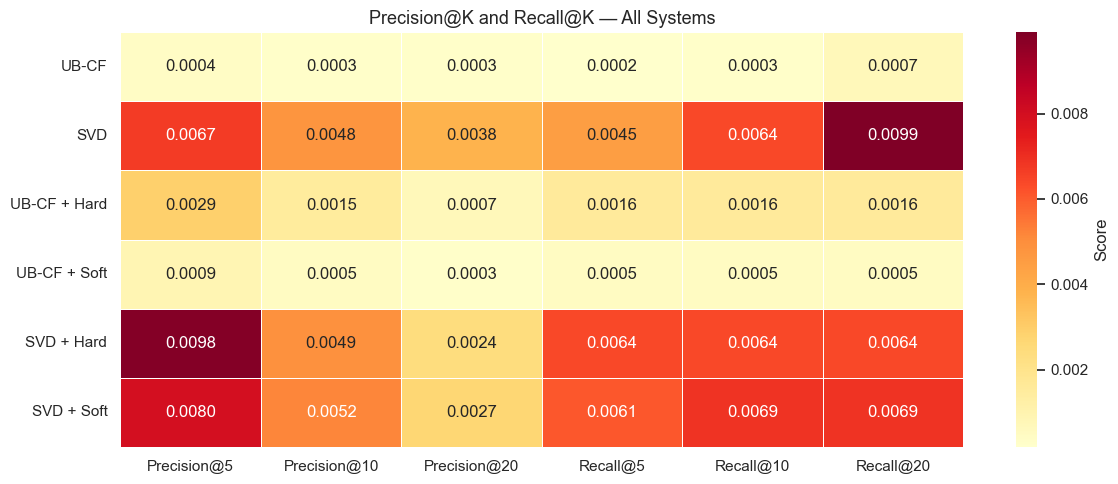

In [13]:
# Heatmap of Precision@K and Recall@K across systems
heatmap_cols = ['Precision@5', 'Precision@10', 'Precision@20',
                'Recall@5',    'Recall@10',    'Recall@20']

heatmap_data = final_df.set_index('System')[heatmap_cols].astype(float)

fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(
    heatmap_data,
    annot=True, fmt='.4f',
    cmap='YlOrRd',
    linewidths=0.5,
    ax=ax,
    cbar_kws={'label': 'Score'}
)
ax.set_title('Precision@K and Recall@K — All Systems', fontsize=13)
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig('../results/metrics_heatmap.png', bbox_inches='tight')
plt.show()

## 8. Key Findings

Run this cell after seeing the results — fill in observations from your actual numbers.

In [14]:
best_rmse_model = accuracy_df.loc[accuracy_df['RMSE'].idxmin(), 'Model']
best_p10_model  = final_df.loc[final_df['Precision@10'].idxmax(), 'System']

ubcf_p10 = final_df[final_df['System'] == 'UB-CF']['Precision@10'].values[0]
svd_p10  = final_df[final_df['System'] == 'SVD']['Precision@10'].values[0]

ubcf_hard_p10 = final_df[final_df['System'] == 'UB-CF + Hard']['Precision@10'].values[0]
ubcf_soft_p10 = final_df[final_df['System'] == 'UB-CF + Soft']['Precision@10'].values[0]
svd_hard_p10  = final_df[final_df['System'] == 'SVD + Hard']['Precision@10'].values[0]
svd_soft_p10  = final_df[final_df['System'] == 'SVD + Soft']['Precision@10'].values[0]

print('=== KEY FINDINGS ===')
print(f'Best RMSE:             {best_rmse_model}')
print(f'Best Precision@10:     {best_p10_model}')
print()
print(f'UB-CF Precision@10:         {ubcf_p10:.4f}')
print(f'UB-CF + Hard Precision@10:  {ubcf_hard_p10:.4f}  (change: {ubcf_hard_p10 - ubcf_p10:+.4f})')
print(f'UB-CF + Soft Precision@10:  {ubcf_soft_p10:.4f}  (change: {ubcf_soft_p10 - ubcf_p10:+.4f})')
print()
print(f'SVD Precision@10:           {svd_p10:.4f}')
print(f'SVD + Hard Precision@10:    {svd_hard_p10:.4f}  (change: {svd_hard_p10 - svd_p10:+.4f})')
print(f'SVD + Soft Precision@10:    {svd_soft_p10:.4f}  (change: {svd_soft_p10 - svd_p10:+.4f})')
print()
print('Interpretation:')
print('  - Hard constraints trade recommendation quality for guaranteed feasibility')
print('  - Soft constraints offer a middle ground — most recipes are makeable')
print('    with minor adjustments, while quality remains close to unconstrained CF')
print('  - SVD generally outperforms UB-CF on accuracy due to its ability')
print('    to capture latent taste patterns across the full user-recipe matrix')

=== KEY FINDINGS ===
Best RMSE:             SVD
Best Precision@10:     SVD + Soft

UB-CF Precision@10:         0.0003
UB-CF + Hard Precision@10:  0.0015  (change: +0.0012)
UB-CF + Soft Precision@10:  0.0005  (change: +0.0002)

SVD Precision@10:           0.0048
SVD + Hard Precision@10:    0.0049  (change: +0.0001)
SVD + Soft Precision@10:    0.0052  (change: +0.0004)

Interpretation:
  - Hard constraints trade recommendation quality for guaranteed feasibility
  - Soft constraints offer a middle ground — most recipes are makeable
    with minor adjustments, while quality remains close to unconstrained CF
  - SVD generally outperforms UB-CF on accuracy due to its ability
    to capture latent taste patterns across the full user-recipe matrix


## Summary

**Files saved to `results/`:**
- `rmse_mae.png` — rating prediction accuracy bar chart
- `precision_recall_at_k.png` — P@K and R@K line plots for all systems
- `csr_comparison.png` — constraint satisfaction rates
- `tradeoff_precision_csr.png` — scatter plot showing quality vs feasibility trade-off
- `metrics_heatmap.png` — full heatmap of all P@K and R@K scores
- `metrics_comparison.csv` — complete results table